# Задача

Анализ лауреатов нобелевской премии.
*  Извлеч данные по нобелевским лауреатм из общедотсупного источника
*  Найти и проанализировать топ-5 стран по количеству лауреатов

# Подготовка окружения

Задание выполнено в Google Colab, и в этой секции я подтягиваю код напрямую из репозитория.
Проверяющему проект это скорее всего не нужно, можно пропустить эту секцию .

Первичное клонирование репозитория:

In [1]:
!git clone -b my-final-task --single-branch https://github.com/shasha-sh/aaa-final-task.git
%cd aaa-final-task

Cloning into 'aaa-final-task'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 5), reused 12 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 9.28 KiB | 9.28 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/aaa-final-task


Обновление кода с github:

In [ ]:
%cd /content/aaa-final-task
!git fetch origin my-final-task
!git checkout my-final-task
!git pull --rebase origin my-final-task

/content/aaa-final-task
From https://github.com/shasha-sh/aaa-final-task
 * branch            my-final-task -> FETCH_HEAD
Already on 'my-final-task'
Your branch is up to date with 'origin/my-final-task'.
From https://github.com/shasha-sh/aaa-final-task
 * branch            my-final-task -> FETCH_HEAD
Already up to date.


Сброс кэша импортов:

In [ ]:
%cd /content/aaa-final-task
import importlib, json_dict_processing, prizes_configs, laureates_configs
importlib.reload(json_dict_processing)
importlib.reload(prizes_configs)
importlib.reload(laureates_configs)

/content/aaa-final-task


<module 'laureates_configs' from '/content/aaa-final-task/laureates_configs.py'>

# Загрузка данных

В этом разделе я подготавливаю данные для анализа :
  1) Получаю данные о лауреатах Нобелевского фонда.
  2) Привожу данные к единому плоскому формату, чтобы дальше с ними было удобно работать.

Необходимые данные находятся публичном API Нобелевского фонда, откуда ответ приходит в формате JSON-словаря. Поэтому данные не требуют сложной предобработки - достаточно проверить базовую корректность структуры ответа.

In [2]:
import requests
URL_LAUREATES = f'https://api.nobelprize.org/2.1/laureates?limit=1200'

laureates_response = requests.get(URL_LAUREATES)
laureates = laureates_response.json()

assert isinstance(laureates, dict)
assert "laureates" in laureates

laureates_list = laureates["laureates"]

assert isinstance(laureates_list, list)
assert len(laureates_list) > 0
assert isinstance(laureates_list[0], dict)
assert all([("knownName" in x) or ("orgName" in x) for x in laureates_list])

Номинантами на премию могут быть люди или организации, и в данных они записаны по-разному. Различаем их по ключам: у людей есть `knownName`, у организаций - `orgName`.  Код проходится по каждому объекту, вспомогательная функция определяет тип записи по этим ключам и приводит её к плоскому, однообразному формату.

**Если какого-то поля в исходных данных нет, в результирующем словаре будет None.**

In [3]:
from laureates_configs import process_orgs, process_persons


def get_laureate_data(laureate: dict) -> dict | None:
    """
    Normalizes a laureate record and labels its type.

    :param laureate: Input laureate dict (from the API).
    :return: Normalized dict with 'laureate_type', or None if undetermined.
    """
    if "knownName" in laureate:
        d = process_persons(laureate)
        d["laureate_type"] = "person"
        return d
    if "orgName" in laureate:
        d = process_orgs(laureate)
        d["laureate_type"] = "org"
        return d
    return None


laureates_data = []

for laureate in laureates['laureates']:
    laureates_data.append(get_laureate_data(laureate))

assert isinstance(laureates_data, list)
assert all((laureate is None) or isinstance(laureate, dict)
                                        for laureate in laureates_data)

 # Формат данных


Перед анализом зафиксируем формат нормализованных данных. Вся информация извлечена на английском языке. В скобках указаны соответствующие пути к полям в исходном JSON.


**Общие поля нормализованных записей**

- `id` — уникальный идентификатор лауреата *(из `id`)*  
- `name` — имя человека или название организации *(из `knownName.en` / `orgName.en`)*  
- `country_now` — современное название страны, где родился человек или где основана организация *(из `birth.place.countryNow.en` / `founded.place.countryNow.en`)*  
- `laureate_type` — тип лауреата: `"person"` или `"org"` *(добавлено на этапе нормализации)*  
- `prizes_relevant` — список призов этого лауреата (см. структуру ниже) *(из `nobelPrizes`, обрабатывается процессором призов)*


**Только для людей** (`laureate_type = "person"`)
- `gender` — пол *(из `gender`)*  
- `birth_year` — год рождения *(год из строки `birth.date`)*  
- `country_birth` — страна рождения *(из `birth.place.country.en`)*


**Только для организаций** (`laureate_type = "org"`)
- `founded_year` — год основания организации *(год из строки `founded.date`)*  
- `country_founded` — страна основания *(из `founded.place.country.en`)*


**Структура элемента в `prizes_relevant`** (каждый элемент — один приз)
- `award_year` — год вручения *(из `awardYear`)*  
- `category_en` — категория приза, напр. _Physics_, _Peace_, _Economic Sciences_ *(из `category.en`)*  
- `prize_amount` — сумма приза на момент вручения *(из `prizeAmount`)*  
- `prize_amount_adjusted` — сумма с поправкой на инфляцию *(из `prizeAmountAdjusted`)*  
- `prize_status` — статус приза *(из `prizeStatus`)*


# Анализ данных


## Вспомогательный функционал для анализа

При анализе понадобится считать несколько независимых метрик. `ops_with_conditions` делает это за один проход по данным, используя заданные списки условий и соответствующие списки названий результатов, операций и селекторов (путей до полей, к которым применяем операцию). Для подсчёта количества (если в `ops` указано `'count'`) применяется только условие из `conditions`, а селектор игнорируется.

Данные на вход:

*  список нормализованных записей (`records`)
*  список предикатов (`conditions`) и такие же по длине списки названий результатов (`labels`), операций (`ops`: допустимые значения только `'count'`, `'sum'`, `'min'`, `'max'`) и селекторов (`selectors`).

Для каждой записи по очереди применяется каждый предикат; если предикат вернул True, к соответствующему результату применяется операция (`count` / `sum` / `min` / `max`).

Ошибки внутри предиката или невозможность выполнить числовую операцию над значением для конкретной записи игнорируются и пропускаются.

Вспомогательные функции

*  `extract(record, selector)` — безопасно извлекает значение из записи про лауреата, если что-то пошло не так, возвращает None без ошибки

*  Операции: `op_count`, `op_sum`, `op_min`, `op_max` - изменяют значения на соответсвующую функцию

Результат — словарь вида *{label: значение}*, где каждое значение соответствует вычесленной операции по соответсвующим полям.

In [4]:
from typing import Callable

def ops_with_conditions(
    records: list[dict[str, object]],
    conditions: list[Callable[[dict[str, object]], bool]],
    labels: list[str],
    ops: list[str],
    selectors: list[str | tuple[str, str]]
) -> dict[str, int | float | list[object]]:
    """
    Run an aggregation per condition.

    For each label you provide:
    - a predicate (record -> bool),
    - an op: "count" | "sum" | "min" | "max"| "union",
    - a selector for non-"count" ops (field name or 2-level path: (k1, k2)).

    Non-numeric selector values are ignored for sum/min/max.

    :param records: Normalized laureate dictionaries.
    :param conditions: Predicates, one per label.
    :param labels: Output names, one per condition.
    :param ops: Operation per label: "count" | "sum" | "min" | "max" | "union".
    :param selectors: Selector per label (ignored conceptually for "count").
    :return: Dict {label: aggregate}.
    """


    def extract(rec: dict[str, object],
                sel: str | tuple[str, str]) -> object | None:
        if isinstance(sel, str):
            return rec.get(sel)
        if isinstance(sel, tuple) and len(sel) == 2:
            outer = rec.get(sel[0])
            if isinstance(outer, dict):
                return outer.get(sel[1])
            return None
        return None


    neutral_el = {
        'min' : float('inf'),
        'max' : float('-inf'),
        'count' : 0,
        'sum' : 0,
        'union' : []
    }


    def op_count(_: dict[str, object],
                 __: str | tuple[str, str],
                 res: int) -> int:
        return res + 1


    def op_sum(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float | int) -> float | int:
        val = extract(rec, sel)
        return res + (val if isinstance(val, (int, float)) else 0)


    def op_max(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float) -> float:
        val = extract(rec, sel)
        return max(res, (float(val) if isinstance(val, (int, float))
                                    else neutral_el["max"]))

    def op_min(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float) -> float:
        val = extract(rec, sel)
        return min(res, (float(val) if isinstance(val, (int, float))
                                    else neutral_el["min"]))


    def op_union(rec: dict[str, object],
                 sel: str | tuple[str, str],
                 res: list[object]) -> list[object]:
        val = extract(rec, sel)
        if val is not None:
            res.append(val)
        return res


    ops_dct = {
        'min' : op_min,
        'max' : op_max,
        'count' : op_count,
        'sum' : op_sum,
        'union' : op_union
    }

    if not (len(labels) == len(conditions) == len(ops) == len(selectors)):
        raise ValueError(
            "conditions, labels, ops, selectors must have the same length"
        )
    for name, op in zip(labels, ops):
        if op not in ops_dct:
            raise ValueError(f"Unsupported op: {op}")

    result = {name: neutral_el[op] for name, op in zip(labels, ops)}

    for rec in records:
        for cond, name, op, selector in zip(conditions, labels, ops, selectors):
            try:
                if cond(rec):
                    result[name] = ops_dct[op](rec, selector, result[name])
            except Exception:
                pass

    return result

## EDA лауреатов

На прошлом этапе мы работали только с записями, которые относятся к людям и организациям, исследую два конкретных формата словаря. Проверим не упустили ли мы еще что-то.

In [5]:
total_count = ops_with_conditions(
    laureates_data,
    conditions=[lambda d: True, lambda d: d is not None],
    labels=["total", "normalized"],
    ops=["count", "count"],
    selectors=["id", "id"],
)


print(f"Total record count (via counter): {total_count["total"]}")
print(f"Normalized record count (via counter): {total_count["normalized"]}")


Total record count (via counter): 1018
Normalized record count (via counter): 1018


Таким образом количества записей относящихся либо к людям, либо к организациям равно искомому количеству записей, то есть мы нормализовали всех существующих лауреатов. Сохраним это значение.

In [7]:
n = total_count["total"]

Сразу посчитаем количество лауреатов-людей и лауреатов-организаций.

In [6]:
type_counts = ops_with_conditions(
    laureates_data,
    conditions=[
        lambda d: d.get("laureate_type") == "person",
        lambda d: d.get("laureate_type") == "org",
    ],
    labels=["person_count", "org_count"],
    ops=["count", "count"],
    selectors=["id", "id"],
)

print(f"Total record count (via counter): {type_counts["person_count"]}")
print(f"Normalized record count (via counter): {type_counts["org_count"]}")

Total record count (via counter): 990
Normalized record count (via counter): 28


Заметим, что количество лауреатов-людей кратно больше.

Проверим насколько полная информация у нас о пользователях.

In [8]:
n = len(laureates_data)

fields = [
    "id", "name", "laureate_type", "country_now",
    "gender", "birth_year", "country_birth",
    "founded_year", "country_founded",
    "prizes_relevant",
]

missing_counts = ops_with_conditions(
    laureates_data,
    conditions=[(lambda f:
                    (lambda d: (f not in d) or (d.get(f) is None))
                )(f) for f in fields],
    labels=fields,
    ops=["count"] * len(fields),
    selectors=["id"] * len(fields),
)

missing_ratios = {k: v / n for k, v in missing_counts.items()}

print("Missing (counts):")
for k in fields:
    print(f"  {k}: {missing_counts[k]}")

print("Missing (ratios):")
for k in fields:
    print(f"  {k}: {missing_ratios[k]:.3f}")


Missing (counts):
  id: 0
  name: 0
  laureate_type: 0
  country_now: 8
  gender: 28
  birth_year: 28
  country_birth: 32
  founded_year: 991
  country_founded: 994
  prizes_relevant: 0
Missing (ratios):
  id: 0.000
  name: 0.000
  laureate_type: 0.000
  country_now: 0.008
  gender: 0.028
  birth_year: 0.028
  country_birth: 0.031
  founded_year: 0.973
  country_founded: 0.976
  prizes_relevant: 0.000


Теперь рассмотрим формат id лауреатов.

In [9]:
ids_res = ops_with_conditions(
    laureates_data,
    conditions=[lambda d: True],
    labels=["ids"],
    ops=["union"],
    selectors=["id"]
)

assert all([id.isdigit() for id in ids_res["ids"]])

ids = [int(id) for id in ids_res["ids"]]


Получили, что все id в строковом формате данных, однако спокойно кастятся к числовому формату. Для удобства так и сделаем.

In [11]:
min_id = min(ids)
max_id = max(ids)

def prize_years_for(laureates, target_id: int) -> list[int]:
    years: set[int] = set()
    t = str(target_id)
    for rec in laureates:
        if str(rec.get("id")) == t:
            for p in rec.get("prizes_relevant") or []:
                y = p.get("award_year")
                if isinstance(y, int):
                    years.add(y)
    return sorted(years)

min_id_years = prize_years_for(laureates_data, min_id)
max_id_years = prize_years_for(laureates_data, max_id)

print(f"Min id: {min_id}, award years: {min_id_years}")
print(f"Max id: {max_id}, award years: {max_id_years}")

Min id: 1, award years: [1901]
Max id: 1060, award years: [2025]


Самый большой и маленький id соответсвуют годам хронологически.

Проверим есть ли записи с повторяющимися id.

In [12]:
from collections import Counter


cnt = Counter(ids)
duplicates = {k: v for k, v in cnt.items() if v > 1}
print("Duplicate IDs:", duplicates if duplicates else "no duplicates")

Duplicate IDs: no duplicates


Дупликатов нет. Соответсвенно если один человек или организация номинировались несколько раз, им давали новый id.

Проверим ли пары айди, которые в отсортированном массиве айдишников различаются более, чем на один?

In [14]:
ids_sorted = sorted(ids)
gaps = []
for prev, curr in zip(ids_sorted, ids_sorted[1:]):
    if curr - prev > 1:
        gaps.append((prev, curr))
print("Gaps between sorted IDs:", gaps if gaps else "no gaps")

Gaps between sorted IDs: [(6, 8), (93, 95), (169, 172), (255, 257), (468, 470), (503, 505), (520, 523), (541, 543), (569, 571), (590, 592), (594, 596), (597, 600), (610, 613), (615, 617), (631, 633), (635, 637), (645, 647), (655, 657), (783, 786), (787, 789), (858, 861), (896, 903), (949, 958), (1009, 1011)]


Такие пары есть. Значит появляется еще один вопрос для анализа о причине пропусков id-номеров. Тем не менее помним, что все id уникальны.

## Топ-5 стран по числу лауреатов

In [17]:
import matplotlib.pyplot as plt


def draw_top(condition, cat_name):
    countries_res = ops_with_conditions(
        laureates_data,
        conditions=[condition],
        labels=["countries"],
        ops=["union"],
        selectors=["country_now"],
    )
    countries = [c for c in countries_res["countries"] if c]
    top5 = Counter(countries).most_common(5)


    x = [name for name, _ in top5]
    y = [cnt for _, cnt in top5]

    plt.figure()
    plt.bar(x, y)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top-5 countries {cat_name}")
    plt.tight_layout()
    plt.show()

Сначала подведем общий топ по всем номинациям.

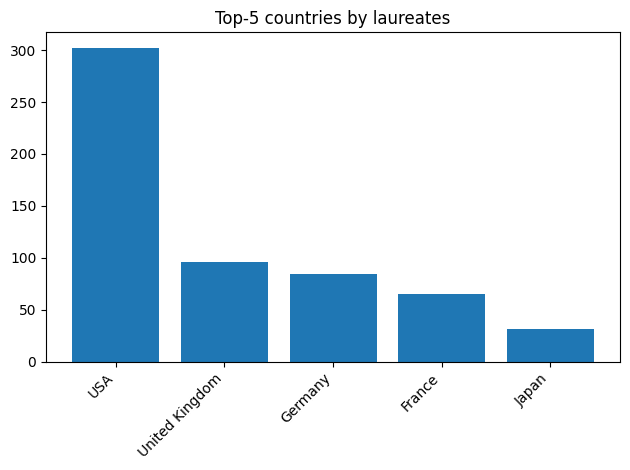

In [18]:
draw_top(lambda d: True, "by laureates")

Теперь посмотрив в разрезе на несколько номинаций. Считаем лауреатов, которые имеют хотя бы один приз в соответсвующей категории.

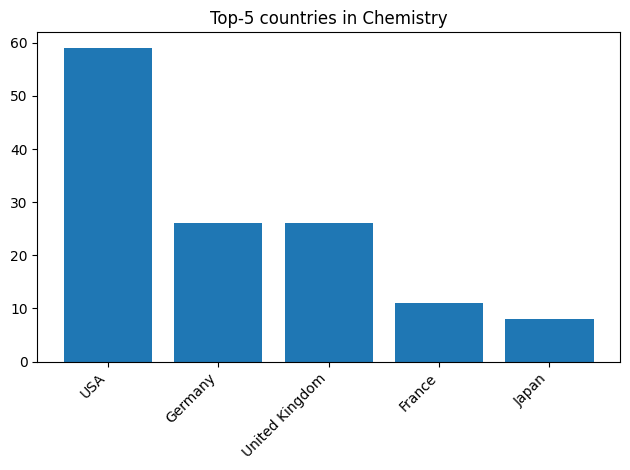

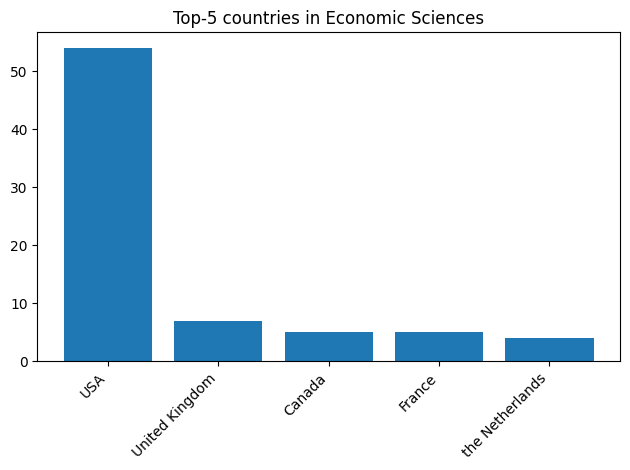

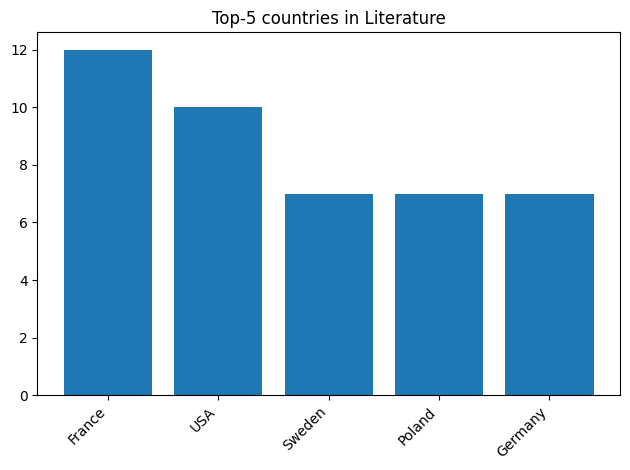

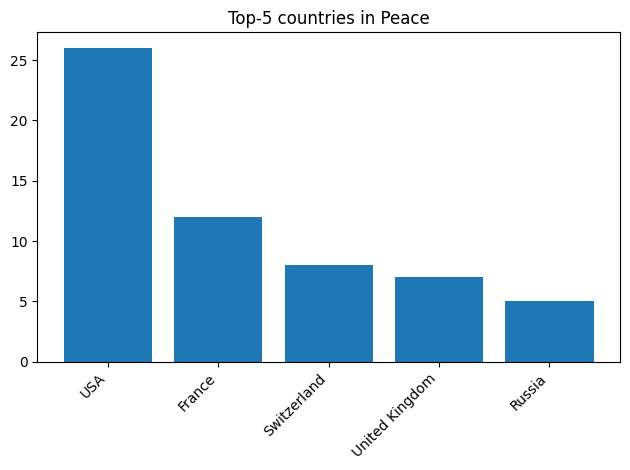

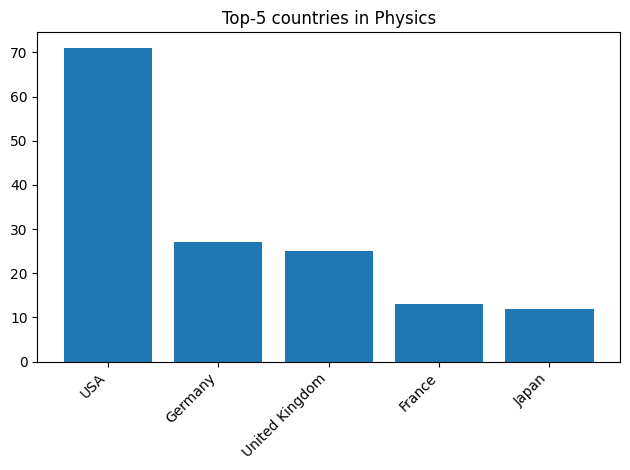

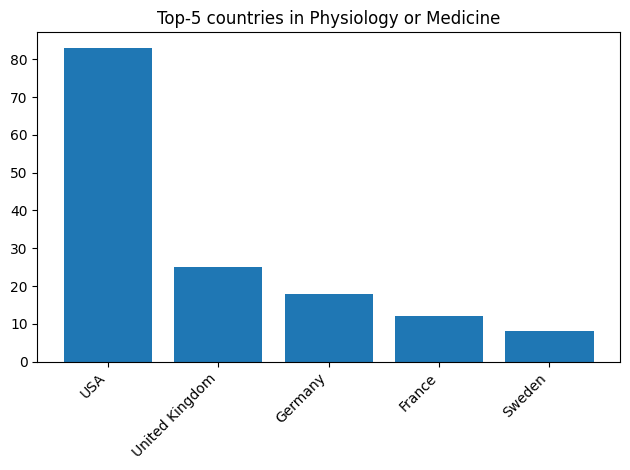

In [19]:
cats = ['Chemistry', 'Economic Sciences', 'Literature', 'Peace', 'Physics', 'Physiology or Medicine']

for cat in cats:
  draw_top(
      lambda d: any(
          p.get("category_en") == cat
          for p in (d.get("prizes_relevant") or [])
      ),
      "in " + cat)

**Вывод:**
*  В целом топ-1 по числу лауреатов - это США (с большим отрывом), затем Великобритания, Германия, Франция, Япония.

*  Экономика: лидируют США с большим отрывом, остальные страны сильно позади.

*  Химия: лидируют США, далее Германия и Великобритания, а у Франции и Японии заметно меньше.

*  Медицина: лидируют США,  Великобритания и Германия - тоже имеют немалую долю стреди лауреатов.

*  Литература: впереди Франция и США, затем Швеция, Польша, Германия — распределение достаточно ровное. Это единственная премия где США не абсолютный лидер.

*  Премия Мира: лидируют США, также в топ попали Франция, Швейцария, Великобритания, Россия.



##